Importing Libraries

In [63]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import date
import joblib

Setup & Load Data

In [64]:
START = "2015-01-01"
TODAY = date.today().strftime("%Y-%m-%d")
SEQ_LENGTH = 200
TICKER = "AAPL"

def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

df = load_data(TICKER)

[*********************100%***********************]  1 of 1 completed


 Feature Engineering, Preparing Dataset & Sequences

In [65]:
df['MA50'] = df['Close'].rolling(50).mean()
df['MA100'] = df['Close'].rolling(100).mean()
df = df.dropna()

features = ['Close', 'MA50', 'MA100']
data = df[features]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
joblib.dump(scaler, 'AAPL_scaler.save')

['AAPL_scaler.save']

In [66]:
def create_sequences(dataset, seq_length=SEQ_LENGTH):
    x, y = [], []
    for i in range(seq_length, len(dataset)):
        x.append(dataset[i-seq_length:i])
        y.append(dataset[i, 0])
    return np.array(x), np.array(y)

x, y = create_sequences(scaled_data)
split = int(0.7 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

GRU MODEL

In [67]:
# Build
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense

model = Sequential([
    GRU(64, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, x.shape[2])),
    Dropout(0.2),
    GRU(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mae'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 200, 64)        │        13,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,273 (149.50 KB)

 Trainable params: 38,273 (149.50 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Train
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32)
model.save(f'{TICKER}_gru_model.h5')

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.0175 - mae: 0.1232 - val_loss: 0.0013 - val_mae: 0.0396
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0015 - mae: 0.0356 - val_loss: 0.0022 - val_mae: 0.0545
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0014 - mae: 0.0345 - val_loss: 0.0015 - val_mae: 0.0452
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0010 - mae: 0.0307 - val_loss: 0.0011 - val_mae: 0.0375
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 9.5276e-04 - mae: 0.0285 - val_loss: 0.0015 - val_mae: 0.0446
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 9.0720e-04 - mae: 0.0283 - val_loss: 0.0017 - val_mae: 0.0482
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 8.1816e-04 - mae: 0.0254 - val_loss: 0.0015 - val_mae: 0.0444
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 8.0011e-04 - mae: 0.0258 - val_loss: 0.0020 - val_mae: 0.0532
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Mean Absolute Error on Test Set: 4.329551051006222
Root Mean Squared Error on Test Set: 5.816281956311646
R-squared on Test Set: 0.9670703063593425


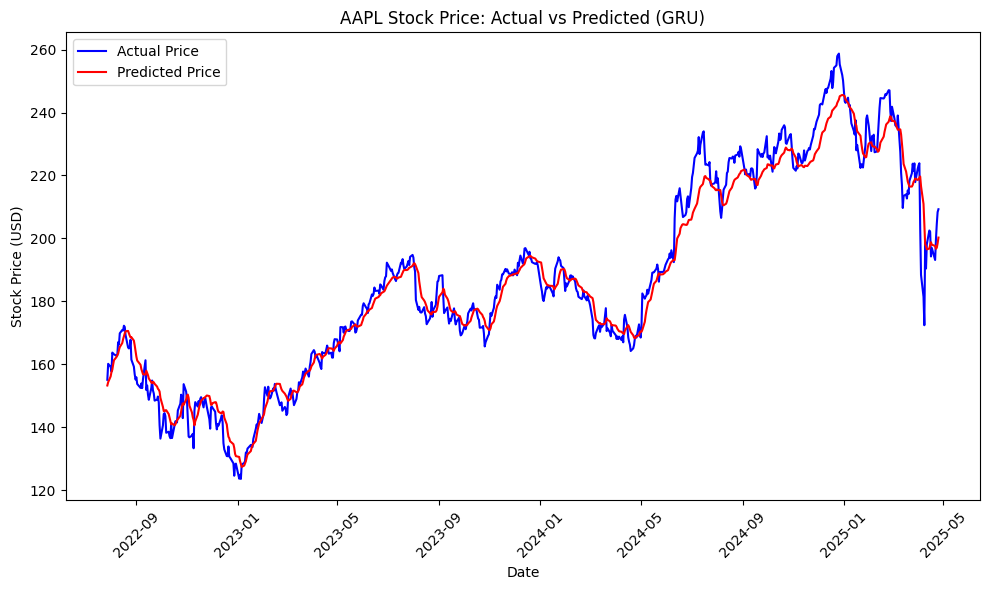

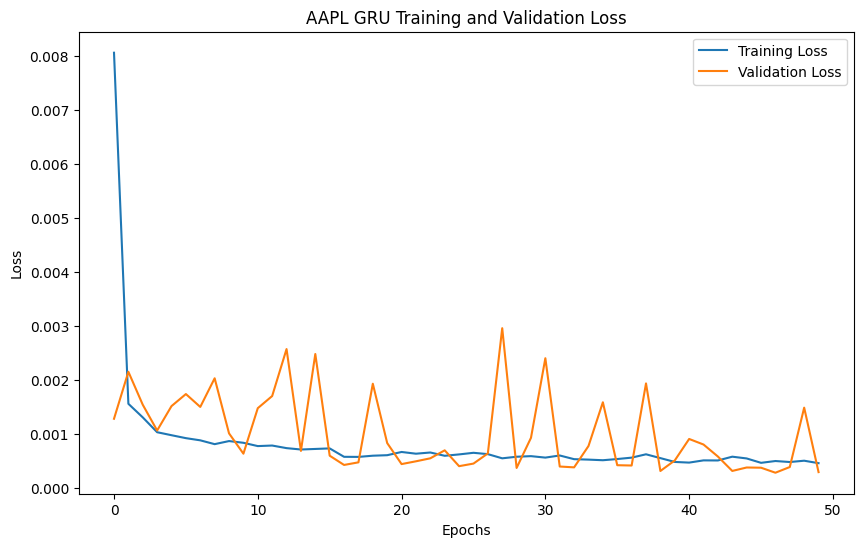

In [69]:
# Predictions and Evaluation
y_pred = model.predict(x_test)
pred_array = np.zeros((len(y_pred), len(features)))
pred_array[:,0] = y_pred.flatten()

test_array = np.zeros((len(y_test), len(features)))
test_array[:,0] = y_test

# Inverse transform
y_pred_rescaled = scaler.inverse_transform(pred_array)[:,0]
y_test_rescaled = scaler.inverse_transform(test_array)[:,0]

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Absolute Error on Test Set: {mae}")
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error on Test Set: {rmse}")
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"R-squared on Test Set: {r2}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Date'].iloc[-len(y_test_rescaled):], y_test_rescaled, label='Actual Price', color='blue')
plt.plot(df['Date'].iloc[-len(y_test_rescaled):], y_pred_rescaled, label='Predicted Price', color='red')
plt.title(f'{TICKER} Stock Price: Actual vs Predicted (GRU)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{TICKER} GRU Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Bi-LSTM  MODEL

In [70]:
# Build
from tensorflow.keras.layers import LSTM, Bidirectional

model = Sequential([
    Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=(SEQ_LENGTH, x.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(64, activation='relu')),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mae'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 200, 128)       │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 200, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,761 (522.50 KB)

 Trainable params: 133,761 (522.50 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# Train
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32)
model.save(f'{TICKER}_bilstm_model.h5')

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - loss: 0.0156 - mae: 0.1144 - val_loss: 0.0016 - val_mae: 0.0435
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0011 - mae: 0.0326 - val_loss: 0.0016 - val_mae: 0.0426
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 9.2352e-04 - mae: 0.0292 - val_loss: 0.0013 - val_mae: 0.0418
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 9.2689e-04 - mae: 0.0281 - val_loss: 0.0015 - val_mae: 0.0453
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 7.0477e-04 - mae: 0.0245 - val_loss: 0.0019 - val_mae: 0.0497
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 6.7938e-04 - mae: 0.0243 - val_loss: 0.0013 - val_mae: 0.0413
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 6.9477e-04 - mae: 0.0238 - val_loss: 0.0015 - val_mae: 0.0436
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 6.6445e-04 - mae: 0.0238 - val_loss: 0.0012 - val_mae: 0.0391
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step
Mean Absolute Error on Test Set: 8.399915708858353
Root Mean Squared Error on Test Set: 10.666341040700672
R-squared on Test Set: 0.8892540844314576


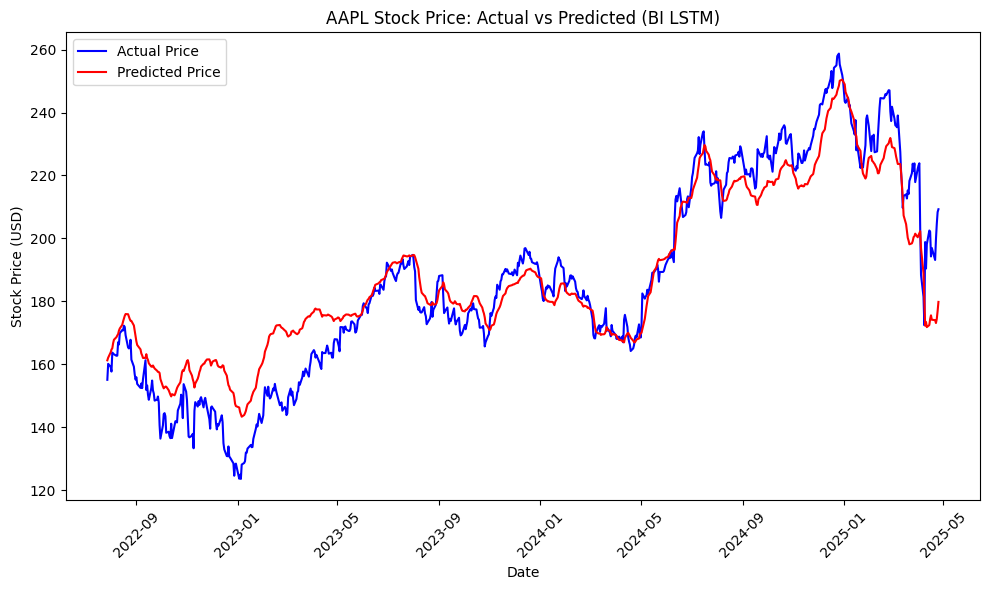

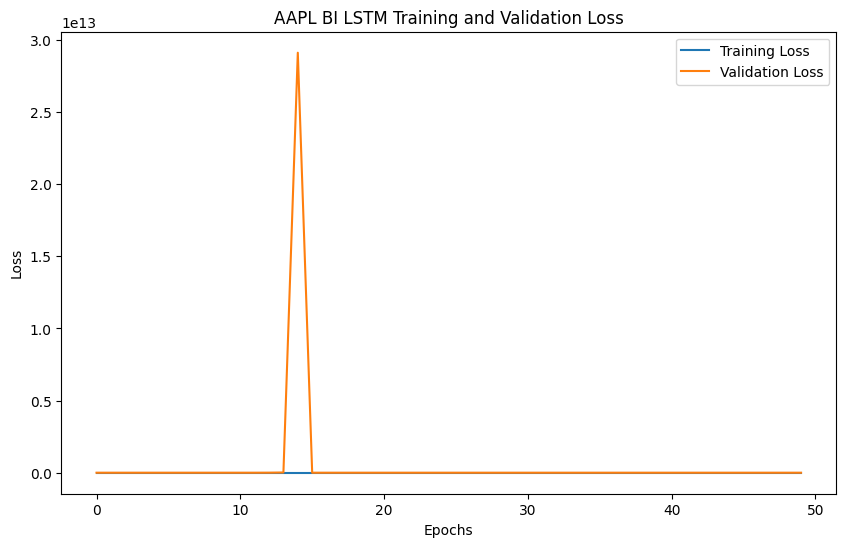

In [72]:
# Predictions and Evaluation
y_pred = model.predict(x_test)
pred_array = np.zeros((len(y_pred), len(features)))
pred_array[:,0] = y_pred.flatten()

test_array = np.zeros((len(y_test), len(features)))
test_array[:,0] = y_test

y_pred_rescaled = scaler.inverse_transform(pred_array)[:,0]
y_test_rescaled = scaler.inverse_transform(test_array)[:,0]

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Absolute Error on Test Set: {mae}")
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error on Test Set: {rmse}")
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"R-squared on Test Set: {r2}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Date'].iloc[-len(y_test_rescaled):], y_test_rescaled, label='Actual Price', color='blue')
plt.plot(df['Date'].iloc[-len(y_test_rescaled):], y_pred_rescaled, label='Predicted Price', color='red')
plt.title(f'{TICKER} Stock Price: Actual vs Predicted (BI LSTM)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{TICKER} BI LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

CNN 1D Model

In [73]:
# Build
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, x.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mae'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 198, 64)        │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 99, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 97, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 50)             │       153,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,693 (651.14 KB)

 Trainable params: 166,693 (651.14 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
# Train
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32)
model.save(f'{TICKER}_cnn1d_model.h5')

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0092 - mae: 0.0751 - val_loss: 0.0028 - val_mae: 0.0591
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0889e-04 - mae: 0.0248 - val_loss: 0.0035 - val_mae: 0.0698
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0690e-04 - mae: 0.0191 - val_loss: 0.0011 - val_mae: 0.0376
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8055e-04 - mae: 0.0158 - val_loss: 0.0014 - val_mae: 0.0431
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0151e-04 - mae: 0.0135 - val_loss: 0.0010 - val_mae: 0.0358
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8277e-04 - mae: 0.0129 - val_loss: 0.0010 - val_mae: 0.0358
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8728e-04 - mae: 0.0136 - val_loss: 0.0012 - val_mae: 0.0396
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5143e-04 - mae: 0.0120 - val_loss: 0.0045 - val_mae: 0.0817
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Mean Absolute Error on Test Set: 9.759490136228596
Root Mean Squared Error on Test Set: 12.046138190179057
R-squared on Test Set: 0.8587486950034974


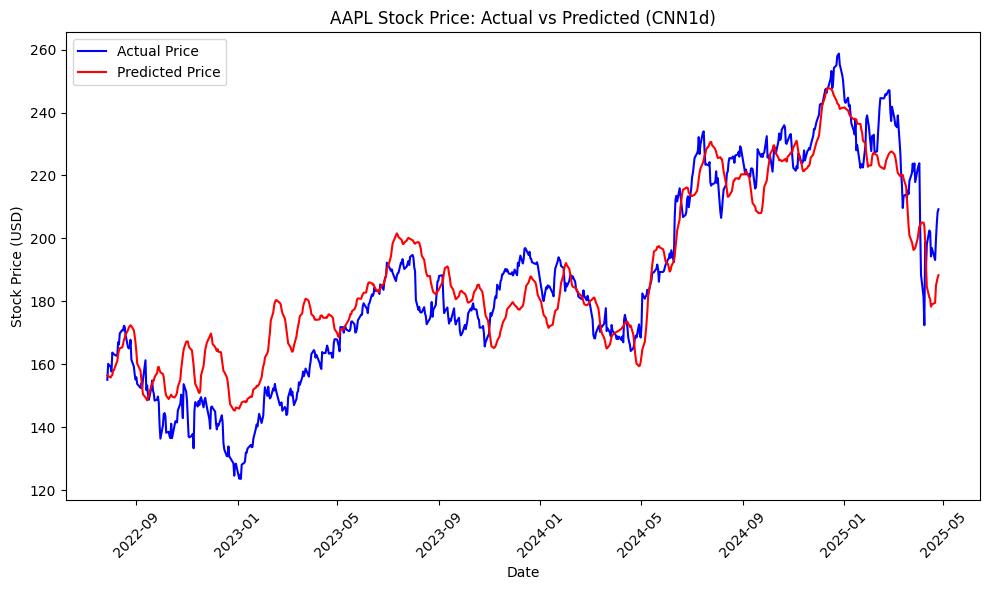

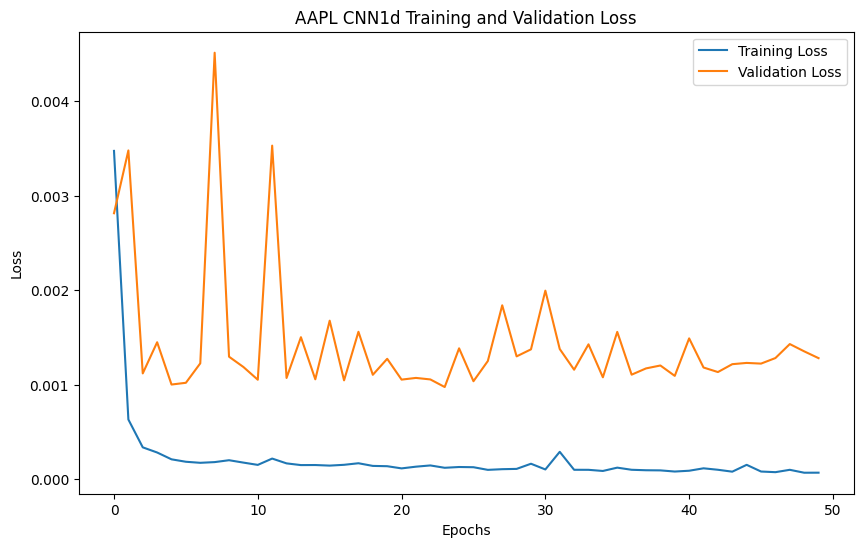

In [75]:
# Predictions and Evaluation
y_pred = model.predict(x_test)
pred_array = np.zeros((len(y_pred), len(features)))
pred_array[:,0] = y_pred.flatten()

test_array = np.zeros((len(y_test), len(features)))
test_array[:,0] = y_test

y_pred_rescaled = scaler.inverse_transform(pred_array)[:,0]
y_test_rescaled = scaler.inverse_transform(test_array)[:,0]

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Absolute Error on Test Set: {mae}")
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error on Test Set: {rmse}")
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"R-squared on Test Set: {r2}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Date'].iloc[-len(y_test_rescaled):], y_test_rescaled, label='Actual Price', color='blue')
plt.plot(df['Date'].iloc[-len(y_test_rescaled):], y_pred_rescaled, label='Predicted Price', color='red')
plt.title(f'{TICKER} Stock Price: Actual vs Predicted (CNN1d)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{TICKER} CNN1d Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

LSTM Model

In [76]:
# Build Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mae'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 200, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,497 (197.25 KB)

 Trainable params: 50,497 (197.25 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32)
model.save(f'{TICKER}_lstm_model.h5')

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - loss: 0.0121 - mae: 0.1014 - val_loss: 0.0022 - val_mae: 0.0490
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0014 - mae: 0.0334 - val_loss: 0.0011 - val_mae: 0.0370
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0010 - mae: 0.0296 - val_loss: 0.0029 - val_mae: 0.0665
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0011 - mae: 0.0293 - val_loss: 7.4498e-04 - val_mae: 0.0308
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 9.6942e-04 - mae: 0.0291 - val_loss: 8.5417e-04 - val_mae: 0.0312
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0011 - mae: 0.0296 - val_loss: 9.6842e-04 - val_mae: 0.0331
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 9.6505e-04 - mae: 0.0273 - val_loss: 7.3473e-04 - val_mae: 0.0305
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 8.0802e-04 - mae: 0.0250 - val_loss: 0.0021 - val_mae: 0.0560
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
Mean Absolute Error on Test Set: 13.354367753621128
Root Mean Squared Error on Test Set: 15.356056641983315
R-squared on Test Set: 0.7704611520054412


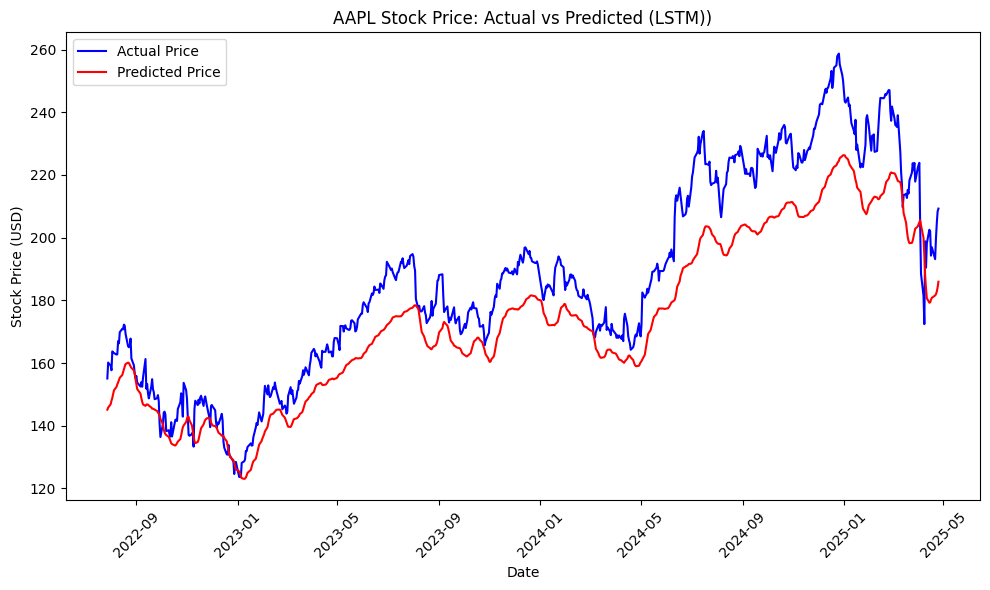

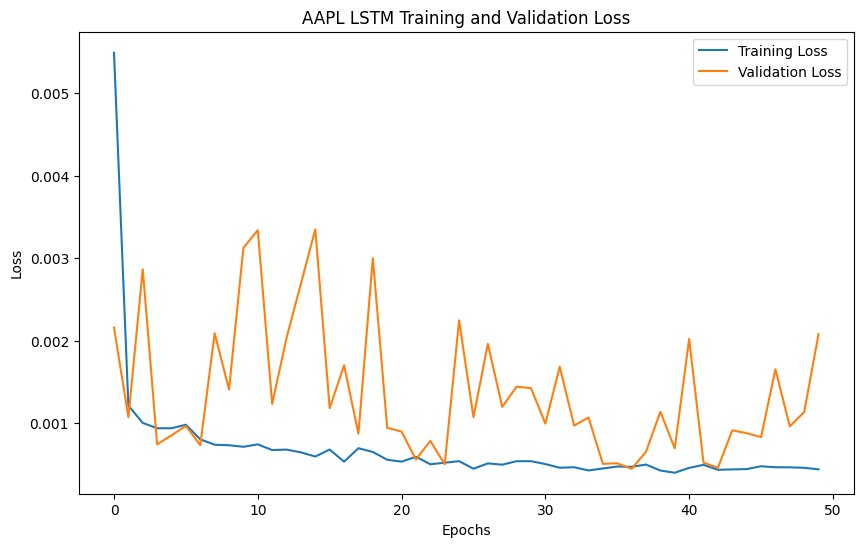

In [78]:
# Predictions and Evaluation
y_pred = model.predict(x_test)
pred_array = np.zeros((len(y_pred), len(features)))
pred_array[:,0] = y_pred.flatten()

test_array = np.zeros((len(y_test), len(features)))
test_array[:,0] = y_test

y_pred_rescaled = scaler.inverse_transform(pred_array)[:,0]
y_test_rescaled = scaler.inverse_transform(test_array)[:,0]

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f"Mean Absolute Error on Test Set: {mae}")
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error on Test Set: {rmse}")
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
print(f"R-squared on Test Set: {r2}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Date'].iloc[-len(y_test_rescaled):], y_test_rescaled, label='Actual Price', color='blue')
plt.plot(df['Date'].iloc[-len(y_test_rescaled):], y_pred_rescaled, label='Predicted Price', color='red')
plt.title(f'{TICKER} Stock Price: Actual vs Predicted (LSTM))')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Loss plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{TICKER} LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
import pandas as pd
import numpy as np
import yfinance as yf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

# Loading models
models = {
    'LSTM': load_model('AAPL_lstm_model.h5'),
    'GRU': load_model('AAPL_gru_model.h5'),
    'Bi-LSTM': load_model('AAPL_bilstm_model.h5'),
    'CNN-1D': load_model('AAPL_cnn1d_model.h5')
}

# Latest AAPL data
START = "2015-01-01"
TODAY = "2025-04-27"
TICKER = "AAPL"

def load_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)
    df.reset_index(inplace=True)
    return df

df = load_data(TICKER, START, TODAY)

# Feature Engineering
df['MA50'] = df['Close'].rolling(50).mean()
df['MA100'] = df['Close'].rolling(100).mean()
df = df.dropna()

features = ['Close', 'MA50', 'MA100']
data = df[features]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Prepare input
SEQ_LENGTH = 200
x_input = scaled_data[-SEQ_LENGTH:]  # shape (200, 3)
x_input = np.expand_dims(x_input, axis=0)

# Prediction for 28 April 2025
predictions = {}

for model_name, model in models.items():
    pred_scaled = model.predict(x_input)

    pred_rescaled = scaler.inverse_transform(np.concatenate((pred_scaled, np.zeros((pred_scaled.shape[0], len(features) - 1))), axis=1))
    pred_actual = pred_rescaled[0][0]

    predictions[model_name] = pred_actual

# results
print("📈 Stock Price Prediction for 28th April 2025 (Apple AAPL):\n")
results = pd.DataFrame.from_dict(predictions, orient='index', columns=['Predicted Price (USD)'])
print(results)

[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
📈 Stock Price Prediction for 28th April 2025 (Apple AAPL):

         Predicted Price (USD)
LSTM                192.310934
GRU                 192.513362
Bi-LSTM             184.938773
CNN-1D              178.425008


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import date

# 1. Settings
START = "2015-01-01"
TODAY = date.today().strftime("%Y-%m-%d")
SEQ_LENGTH = 200  # Longer sequences for LSTM
TICKERS = ["MSFT", "GOOGL", "AMZN", "TSLA"]

# 2. Load Data
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

# 3. Feature Engineering: Add moving averages
def add_moving_averages(df):
    df['MA50'] = df['Close'].rolling(50).mean()
    df['MA100'] = df['Close'].rolling(100).mean()
    df = df.dropna()
    return df

# 4. Prepare dataset
def prepare_dataset(df):
    features = ['Close', 'MA50', 'MA100']
    data = df[features]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# 5. Create Sequences
def create_sequences(dataset, seq_length=SEQ_LENGTH):
    x, y = [], []
    for i in range(seq_length, len(dataset)):
        x.append(dataset[i-seq_length:i])
        y.append(dataset[i, 0])  # Predict Close price
    return np.array(x), np.array(y)

# 6. Build Model
def build_lstm_model(input_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model

# 7. Training and Evaluation Loop
def train_and_evaluate_model(ticker):
    print(f"Training model for {ticker}...")

    # Load and preprocess data
    df = load_data(ticker)
    df = add_moving_averages(df)
    scaled_data, scaler = prepare_dataset(df)

    # Create sequences
    x, y = create_sequences(scaled_data)

    # Train-Test Split
    split = int(0.7 * len(x))
    x_train, y_train = x[:split], y[:split]
    x_test, y_test = x[split:], y[split:]

    # Build and train the model
    model = build_lstm_model(input_shape=(SEQ_LENGTH, x.shape[2]))
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32)

    # Save the model
    model.save(f'{ticker}_lstm_model.h5')

    # 8. Evaluate the model
    y_pred = model.predict(x_test)

    # Rescale the predictions and actual values
    y_pred_rescaled = y_pred * scaler.scale_[0] + scaler.min_[0]
    y_test_rescaled = y_test * scaler.scale_[0] + scaler.min_[0]

    # Evaluate using Mean Absolute Error
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

    # Evaluate using Mean Squared Error (RMSE)
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)

    # Evaluate using R-squared
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    # Print evaluation results
    print(f"\n{ticker} Model Evaluation:")
    print(f"Mean Absolute Error on Test Set: {mae}")
    print(f"Root Mean Squared Error on Test Set: {rmse}")
    print(f"R-squared on Test Set: {r2}\n")

# 10. Pipeline for Multiple Stocks
for ticker in TICKERS:
    train_and_evaluate_model(ticker)

Training model for MSFT...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 211ms/step - loss: 0.0203 - mae: 0.1345 - val_loss: 0.0031 - val_mae: 0.0631
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - loss: 0.0019 - mae: 0.0404 - val_loss: 0.0059 - val_mae: 0.0978
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - loss: 0.0014 - mae: 0.0349 - val_loss: 0.0053 - val_mae: 0.0922
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 207ms/step - loss: 0.0014 - mae: 0.0341 - val_loss: 0.0017 - val_mae: 0.0495
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 221ms/step - loss: 0.0010 - mae: 0.0285 - val_loss: 7.2200e-04 - val_mae: 0.0316
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - loss: 9.6698e-04 - mae: 0.0279 - val_loss: 9.3313e-04 - val_mae: 0.0361
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - loss: 0.0011 - mae: 0.0290 - val_loss: 0.0045 - val_mae: 0.0845
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - loss: 9.5745e-04 - mae: 0.0289 - val_loss: 0.0024 - val_mae: 0.0602
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step

MSFT Model Evaluation:
Mean Absolute Error on Test Set: 0.00011216013634609674
Root Mean Squared Error on Test Set: 0.00013124669993055114
R-squared on Test Set: 0.8854711254570938

Training model for GOOGL...


[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 209ms/step - loss: 0.0202 - mae: 0.1401 - val_loss: 0.0027 - val_mae: 0.0616
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - loss: 0.0020 - mae: 0.0432 - val_loss: 0.0022 - val_mae: 0.0503
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - loss: 0.0015 - mae: 0.0360 - val_loss: 0.0015 - val_mae: 0.0434
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - loss: 0.0014 - mae: 0.0344 - val_loss: 0.0017 - val_mae: 0.0475
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - loss: 0.0014 - mae: 0.0345 - val_loss: 0.0011 - val_mae: 0.0377
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - loss: 0.0011 - mae: 0.0306 - val_loss: 0.0017 - val_mae: 0.0476
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - loss: 0.0011 - mae: 0.0316 - val_loss: 0.0012 - val_mae: 0.0393
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 216ms/step - loss: 0.0012 - mae: 0.0306 - val_loss: 0.0023 - val_mae: 0.0554
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - loss

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step

GOOGL Model Evaluation:
Mean Absolute Error on Test Set: 0.00018764714801025042
Root Mean Squared Error on Test Set: 0.0002460196060595259
R-squared on Test Set: 0.9357670736852617

Training model for AMZN...


[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 213ms/step - loss: 0.0322 - mae: 0.1847 - val_loss: 0.0055 - val_mae: 0.0920
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - loss: 0.0033 - mae: 0.0602 - val_loss: 0.0026 - val_mae: 0.0633
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 0.0023 - mae: 0.0486 - val_loss: 0.0014 - val_mae: 0.0450
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - loss: 0.0023 - mae: 0.0474 - val_loss: 0.0019 - val_mae: 0.0525
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - loss: 0.0021 - mae: 0.0458 - val_loss: 0.0015 - val_mae: 0.0459
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - loss: 0.0018 - mae: 0.0420 - val_loss: 8.9534e-04 - val_mae: 0.0316
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - loss: 0.0018 - mae: 0.0420 - val_loss: 0.0017 - val_mae: 0.0469
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - loss: 0.0017 - mae: 0.0405 - val_loss: 0.0027 - val_mae: 0.0622
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - l

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step

AMZN Model Evaluation:
Mean Absolute Error on Test Set: 0.00015332666137545564
Root Mean Squared Error on Test Set: 0.00019989428960618652
R-squared on Test Set: 0.9436808792557975

Training model for TSLA...


[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 216ms/step - loss: 0.0141 - mae: 0.0983 - val_loss: 0.0047 - val_mae: 0.0733
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - loss: 0.0019 - mae: 0.0352 - val_loss: 0.0040 - val_mae: 0.0753
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - loss: 0.0018 - mae: 0.0324 - val_loss: 0.0023 - val_mae: 0.0542
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - loss: 0.0012 - mae: 0.0267 - val_loss: 0.0017 - val_mae: 0.0438
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - loss: 0.0015 - mae: 0.0278 - val_loss: 0.0014 - val_mae: 0.0423
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - loss: 0.0012 - mae: 0.0253 - val_loss: 0.0021 - val_mae: 0.0536
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - loss: 0.0013 - mae: 0.0277 - val_loss: 0.0014 - val_mae: 0.0403
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - loss: 0.0012 - mae: 0.0257 - val_loss: 0.0016 - val_mae: 0.0452
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - loss:

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step

TSLA Model Evaluation:
Mean Absolute Error on Test Set: 8.275334940068907e-05
Root Mean Squared Error on Test Set: 9.897538146360596e-05
R-squared on Test Set: 0.8897810824827895

Training model for FB...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: YFTzMissingError('possibly delisted; no timezone found')


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by MinMaxScaler.

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import date

# 1. Settings
START = "2015-01-01"
TODAY = date.today().strftime("%Y-%m-%d")
SEQ_LENGTH = 200  # Longer sequences for LSTM
TICKERS = ["NFLX", "NVDA", "AMD", "BA"]  # Add your stocks here

# 2. Load Data
def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

# 3. Feature Engineering: Add moving averages
def add_moving_averages(df):
    df['MA50'] = df['Close'].rolling(50).mean()
    df['MA100'] = df['Close'].rolling(100).mean()
    df = df.dropna()
    return df

# 4. Prepare dataset
def prepare_dataset(df):
    features = ['Close', 'MA50', 'MA100']
    data = df[features]
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# 5. Create Sequences
def create_sequences(dataset, seq_length=SEQ_LENGTH):
    x, y = [], []
    for i in range(seq_length, len(dataset)):
        x.append(dataset[i-seq_length:i])
        y.append(dataset[i, 0])  # Predict Close price
    return np.array(x), np.array(y)

# 6. Build Model
def build_lstm_model(input_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model

# 7. Training and Evaluation Loop
def train_and_evaluate_model(ticker):
    print(f"Training model for {ticker}...")

    # Load and preprocess data
    df = load_data(ticker)
    df = add_moving_averages(df)
    scaled_data, scaler = prepare_dataset(df)

    # Create sequences
    x, y = create_sequences(scaled_data)

    # Train-Test Split
    split = int(0.7 * len(x))
    x_train, y_train = x[:split], y[:split]
    x_test, y_test = x[split:], y[split:]

    # Build and train the model
    model = build_lstm_model(input_shape=(SEQ_LENGTH, x.shape[2]))
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32)

    # Save the model
    model.save(f'{ticker}_lstm_model.h5')

    # 8. Evaluate the model
    y_pred = model.predict(x_test)

    # Rescale the predictions and actual values
    y_pred_rescaled = y_pred * scaler.scale_[0] + scaler.min_[0]
    y_test_rescaled = y_test * scaler.scale_[0] + scaler.min_[0]

    # Evaluate using Mean Absolute Error
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

    # Evaluate using Mean Squared Error (RMSE)
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)

    # Evaluate using R-squared
    r2 = r2_score(y_test_rescaled, y_pred_rescaled)

    # Print evaluation results
    print(f"\n{ticker} Model Evaluation:")
    print(f"Mean Absolute Error on Test Set: {mae}")
    print(f"Root Mean Squared Error on Test Set: {rmse}")
    print(f"R-squared on Test Set: {r2}\n")

# 10. Pipeline for Multiple Stocks
for ticker in TICKERS:
    train_and_evaluate_model(ticker)

Training model for NFLX...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 242ms/step - loss: 0.0172 - mae: 0.1374 - val_loss: 0.0036 - val_mae: 0.0541
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - loss: 0.0021 - mae: 0.0457 - val_loss: 8.4119e-04 - val_mae: 0.0325
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - loss: 0.0012 - mae: 0.0355 - val_loss: 0.0010 - val_mae: 0.0364
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - loss: 9.9200e-04 - mae: 0.0312 - val_loss: 6.1145e-04 - val_mae: 0.0272
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 196ms/step - loss: 9.9969e-04 - mae: 0.0313 - val_loss: 0.0022 - val_mae: 0.0525
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - loss: 7.9385e-04 - mae: 0.0287 - val_loss: 9.6323e-04 - val_mae: 0.0325
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - loss: 9.3238e-04 - mae: 0.0307 - val_loss: 0.0011 - val_mae: 0.0351
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - loss: 9.1834e-04 - mae: 0.0296 - val_loss: 0.0011 - val_mae: 0.0348
Epoch 9/50
51/51

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step

NFLX Model Evaluation:
Mean Absolute Error on Test Set: 3.375244931841851e-05
Root Mean Squared Error on Test Set: 4.906958434482242e-05
R-squared on Test Set: 0.9503890196939203

Training model for NVDA...


[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 241ms/step - loss: 0.0010 - mae: 0.0304 - val_loss: 0.0121 - val_mae: 0.1057
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 234ms/step - loss: 1.4468e-04 - mae: 0.0108 - val_loss: 0.0034 - val_mae: 0.0616
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - loss: 1.1582e-04 - mae: 0.0096 - val_loss: 0.0036 - val_mae: 0.0647
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 250ms/step - loss: 9.1717e-05 - mae: 0.0087 - val_loss: 0.0046 - val_mae: 0.0747
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 255ms/step - loss: 9.0721e-05 - mae: 0.0086 - val_loss: 0.0015 - val_mae: 0.0405
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 231ms/step - loss: 7.5736e-05 - mae: 0.0079 - val_loss: 0.0031 - val_mae: 0.0588
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - loss: 9.4306e-05 - mae: 0.0098 - val_loss: 0.0080 - val_mae: 0.1000
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - loss: 7.5302e-05 - mae: 0.0080 - val_loss: 0.0014 - val_mae: 0.0366
Epoch 9/50
51/51 ━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step

NVDA Model Evaluation:
Mean Absolute Error on Test Set: 0.0008737966509435793
Root Mean Squared Error on Test Set: 0.001288190594359906
R-squared on Test Set: 0.5988177231937539

Training model for AMD...


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 229ms/step - loss: 0.0119 - mae: 0.0977 - val_loss: 0.0030 - val_mae: 0.0621
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 203ms/step - loss: 0.0019 - mae: 0.0362 - val_loss: 0.0050 - val_mae: 0.0779
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - loss: 0.0015 - mae: 0.0353 - val_loss: 0.0019 - val_mae: 0.0464
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step - loss: 0.0011 - mae: 0.0301 - val_loss: 0.0016 - val_mae: 0.0429
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - loss: 0.0013 - mae: 0.0315 - val_loss: 0.0013 - val_mae: 0.0393
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - loss: 9.0091e-04 - mae: 0.0261 - val_loss: 0.0013 - val_mae: 0.0390
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - loss: 9.8810e-04 - mae: 0.0267 - val_loss: 0.0040 - val_mae: 0.0737
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 216ms/step - loss: 0.0010 - mae: 0.0276 - val_loss: 0.0020 - val_mae: 0.0530
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step

AMD Model Evaluation:
Mean Absolute Error on Test Set: 0.00011613966607377866
Root Mean Squared Error on Test Set: 0.00015057701298848216
R-squared on Test Set: 0.9647857837110045

Training model for BA...


[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 216ms/step - loss: 0.0582 - mae: 0.2559 - val_loss: 0.0013 - val_mae: 0.0409
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - loss: 0.0070 - mae: 0.0840 - val_loss: 8.1917e-04 - val_mae: 0.0326
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - loss: 0.0045 - mae: 0.0652 - val_loss: 6.4208e-04 - val_mae: 0.0282
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - loss: 0.0050 - mae: 0.0678 - val_loss: 7.6050e-04 - val_mae: 0.0301
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - loss: 0.0051 - mae: 0.0687 - val_loss: 7.0656e-04 - val_mae: 0.0301
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - loss: 0.0038 - mae: 0.0606 - val_loss: 6.2453e-04 - val_mae: 0.0270
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - loss: 0.0033 - mae: 0.0566 - val_loss: 0.0012 - val_mae: 0.0411
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - loss: 0.0042 - mae: 0.0628 - val_loss: 5.3030e-04 - val_mae: 0.0250
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step

BA Model Evaluation:
Mean Absolute Error on Test Set: 5.4682597005463026e-05
Root Mean Squared Error on Test Set: 7.285568413074436e-05
R-squared on Test Set: 0.91038571203542

